# Anomaly Detection in ECG Data Using LSTM-AE Architecture

## Import Essential Libreries

In [74]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from pathlib import Path
from glob import glob
import os
import shutil
import pickle
import time
import copy
import random

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# ARFF file handling
from scipy.io.arff import loadarff

# PyTorch
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models

# Progress bar
from tqdm import tqdm

In [2]:
# Matplotlib settings for Jupyter Notebooks
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Seaborn style and color palette
sns.set(style="darkgrid", palette="deep", font_scale=1.1)

# Default figure size for plots
plt.rcParams["figure.figsize"] = (10, 6)

# Seed initialization for reproducibility
RANDOM_SEED = 134
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {device}")

The device is cuda


## Loading Data & EDA

In [7]:
# Load training data from ARFF file
train_file_path = "./ECG5000/ECG5000_TRAIN.arff"
with open(train_file_path) as f:
    data, _ = loadarff(f)
    train = pd.DataFrame(data)

# Load test data from ARFF file
test_file_path = "./ECG5000/ECG5000_TEST.arff"
with open(test_file_path) as f:
    data, _ = loadarff(f)
    test = pd.DataFrame(data)

In [8]:
# Combine training and test data into a single DataFrame
df = pd.concat([train, test])

# Display the first few rows of the combined DataFrame
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [9]:
# Display unique values in the 'target' column
unique_targets = df["target"].unique()
print(unique_targets)

[b'1' b'2' b'3' b'4' b'5']


In [10]:
# Get the number of unique values in the 'att140' column
num_unique_att140 = len(df['att140'].unique())
print(num_unique_att140)

5000


In [11]:
# Define class names for the target classes
class_names = ['Normal', 'PVC', 'R on T', 'SP', 'UB']

# Rename the last column to 'target'
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

# Decode the 'target' column from bytes to string
df['target'] = df['target'].str.decode('utf-8')

# Display the count of each unique value in the 'target' column
target_counts = df['target'].value_counts()
print(target_counts)

target
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64


/tmp/ipykernel_152511/1016779228.py:5: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.countplot(data=df, x='target', palette=colors, hue='target', legend=False)
/tmp/ipykernel_152511/1016779228.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


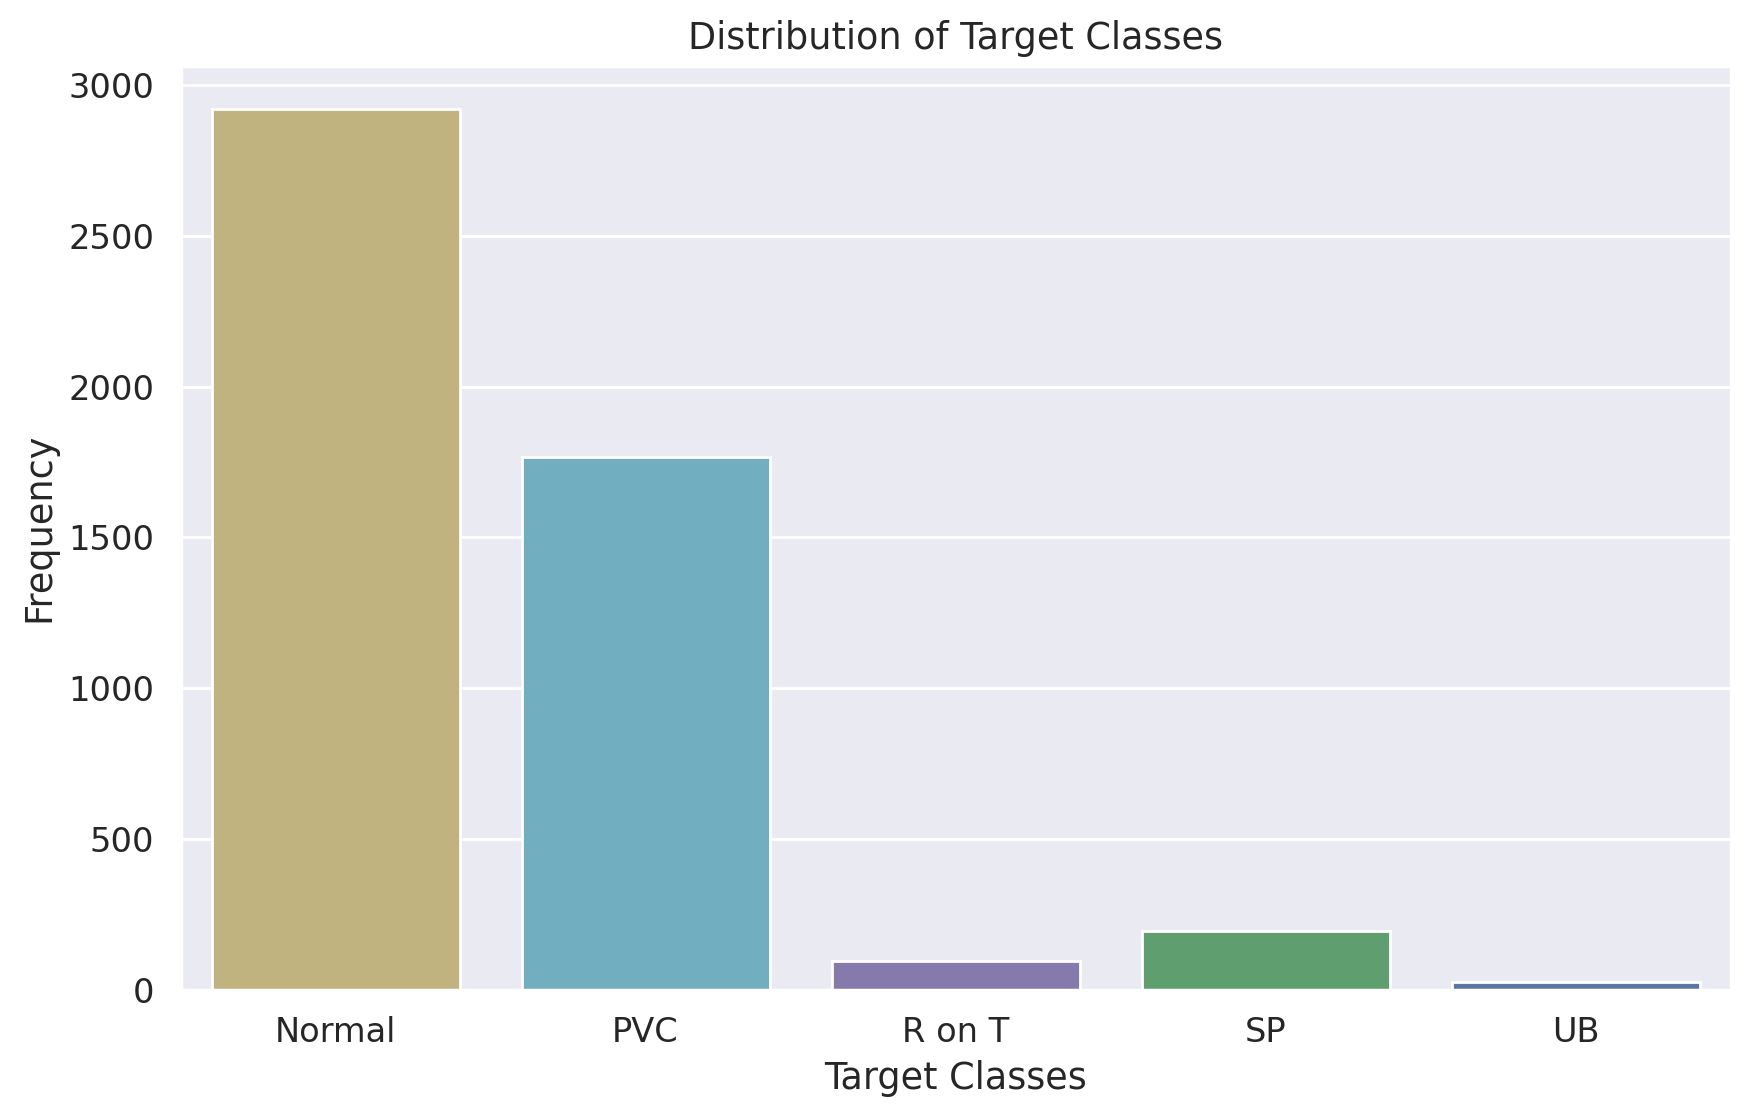

In [12]:
# Define colors for the countplot
colors = ['y', 'c', 'm', 'g', 'b', 'r']

# Create the countplot
ax = sns.countplot(data=df, x='target', palette=colors, hue='target', legend=False)

# Customize x-axis labels to match class names
ax.set_xticklabels(class_names)

# Set axis labels and plot title
ax.set_xlabel('Target Classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Target Classes')

# Display the plot
plt.show()

In [13]:
# Rename the last column to 'label'
column_names = list(df.columns)
column_names[-1] = "label"
df.columns = column_names

# Convert the 'label' column to integer type
df["label"] = df["label"].astype('int32')

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Display the first 3 rows of the DataFrame
df.head(3)


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,label
0,0.095953,0.176663,0.202666,0.130480,0.053099,0.054928,0.096500,0.115644,0.131840,0.179107,...,-2.897533,-3.419289,-3.995034,-4.325194,-4.143567,-3.708346,-3.276323,-2.476603,-1.103730,2
1,1.262039,0.252945,-0.772889,-1.661869,-2.407388,-2.785979,-2.800158,-2.678961,-2.453753,-2.080578,...,-2.953539,-3.431749,-3.508566,-2.909741,-2.076063,-1.045157,0.018653,0.620895,1.218082,2
2,-0.054996,-0.509445,-0.852320,-1.518126,-1.817344,-1.917368,-2.082339,-2.097093,-2.004087,-1.844955,...,-2.113786,-2.808378,-3.395283,-3.844003,-4.088786,-3.428733,-2.583466,-2.214900,-0.647059,2


In [14]:
# Print the count of each unique value in the 'label' column
print(df["label"].value_counts())

# Get the unique values in the 'label' column
unique_labels = df["label"].unique()
print(unique_labels)

label
1    2919
2    1767
4     194
3      96
5      24
Name: count, dtype: int64
[2 1 3 4 5]


In [15]:
def plot_time_series_sample(data_df, loc, color):
    # Create a copy of the DataFrame and drop the 'label' column
    tmp_df = data_df.copy()
    tmp_df = tmp_df.drop(columns=["label"])
    
    # Select the row specified by 'loc' and transpose it
    tmp_df = tmp_df.iloc[loc].transpose().reset_index()

    # Rename columns for plotting
    column_names = list(tmp_df.columns)
    column_names[-1] = "y"  # Rename last column to 'y'
    column_names[0] = "x"   # Rename first column to 'x'
    tmp_df.columns = column_names
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.lineplot(data=tmp_df, x="x", y="y", ax=ax, color=color)
    
    # Customize the plot
    ax.set_title("ECG of a Heartbeat", fontsize=14)
    ax.set_ylabel("Voltage (Amplitude)")
    ax.set_xlabel("Timesteps")
    ax.set_xticklabels([])  # Hide x-axis tick labels
    
    # Adjust layout
    fig.tight_layout()
    plt.show()

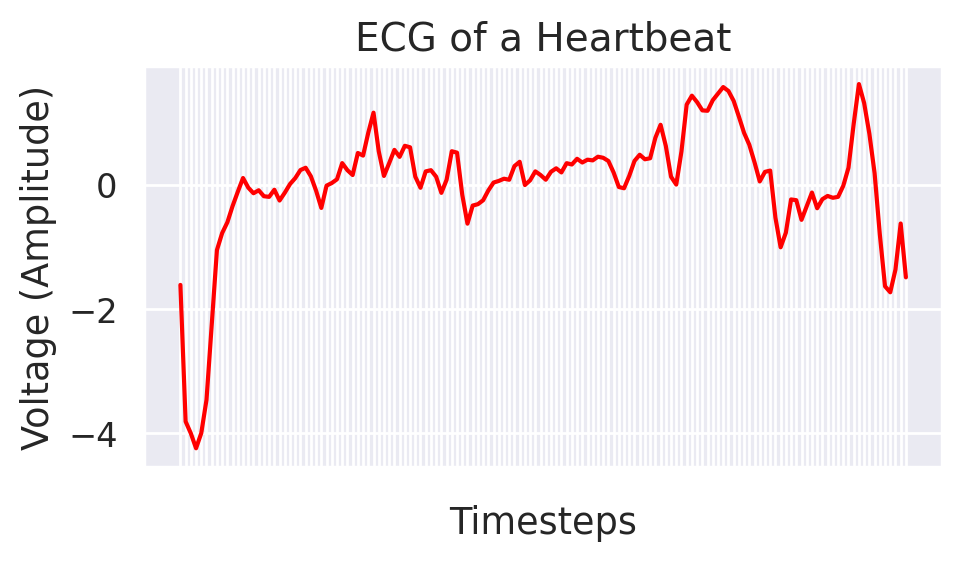

In [16]:
plot_time_series_sample(df, 17, "red")

In [17]:
def plot_time_series(label, data_df, ax, color):
    # Create a copy of the DataFrame and filter by the specified label
    tmp_df = data_df.copy()
    tmp_df = tmp_df[tmp_df["label"] == label]
    tmp_df = tmp_df.drop(columns=["label"])
    
    # Transpose the DataFrame for plotting
    tmp_df = tmp_df.transpose()
    
    # Calculate mean, standard deviation, and confidence intervals
    tmp_df['std'] = tmp_df.std(axis=1)
    tmp_df['mean'] = tmp_df.mean(axis=1)
    tmp_df['ci_lower'] = tmp_df['mean'] - tmp_df['std']
    tmp_df['ci_upper'] = tmp_df['mean'] + tmp_df['std']
    
    # Reset index for plotting
    tmp_df = tmp_df.reset_index()
    
    # Plot the mean time series
    sns.lineplot(data=tmp_df, x="index", y="mean", ax=ax, color=color)
    
    # Plot the confidence interval
    ax.fill_between(tmp_df['index'], tmp_df['ci_lower'], tmp_df['ci_upper'], color=color, alpha=0.15)
    
    # Define class labels
    class_dict = {1: "Normal", 2: "PVC", 3: "R on T", 4: "SP", 5: "UB"}
    
    # Set the title and labels
    ax.set_title(f"Label: {class_dict[label]}")
    ax.set_ylabel("Voltage (Amplitude)")
    ax.set_xlabel("Timesteps")
    ax.set_xticklabels([])  # Hide x-axis tick labels

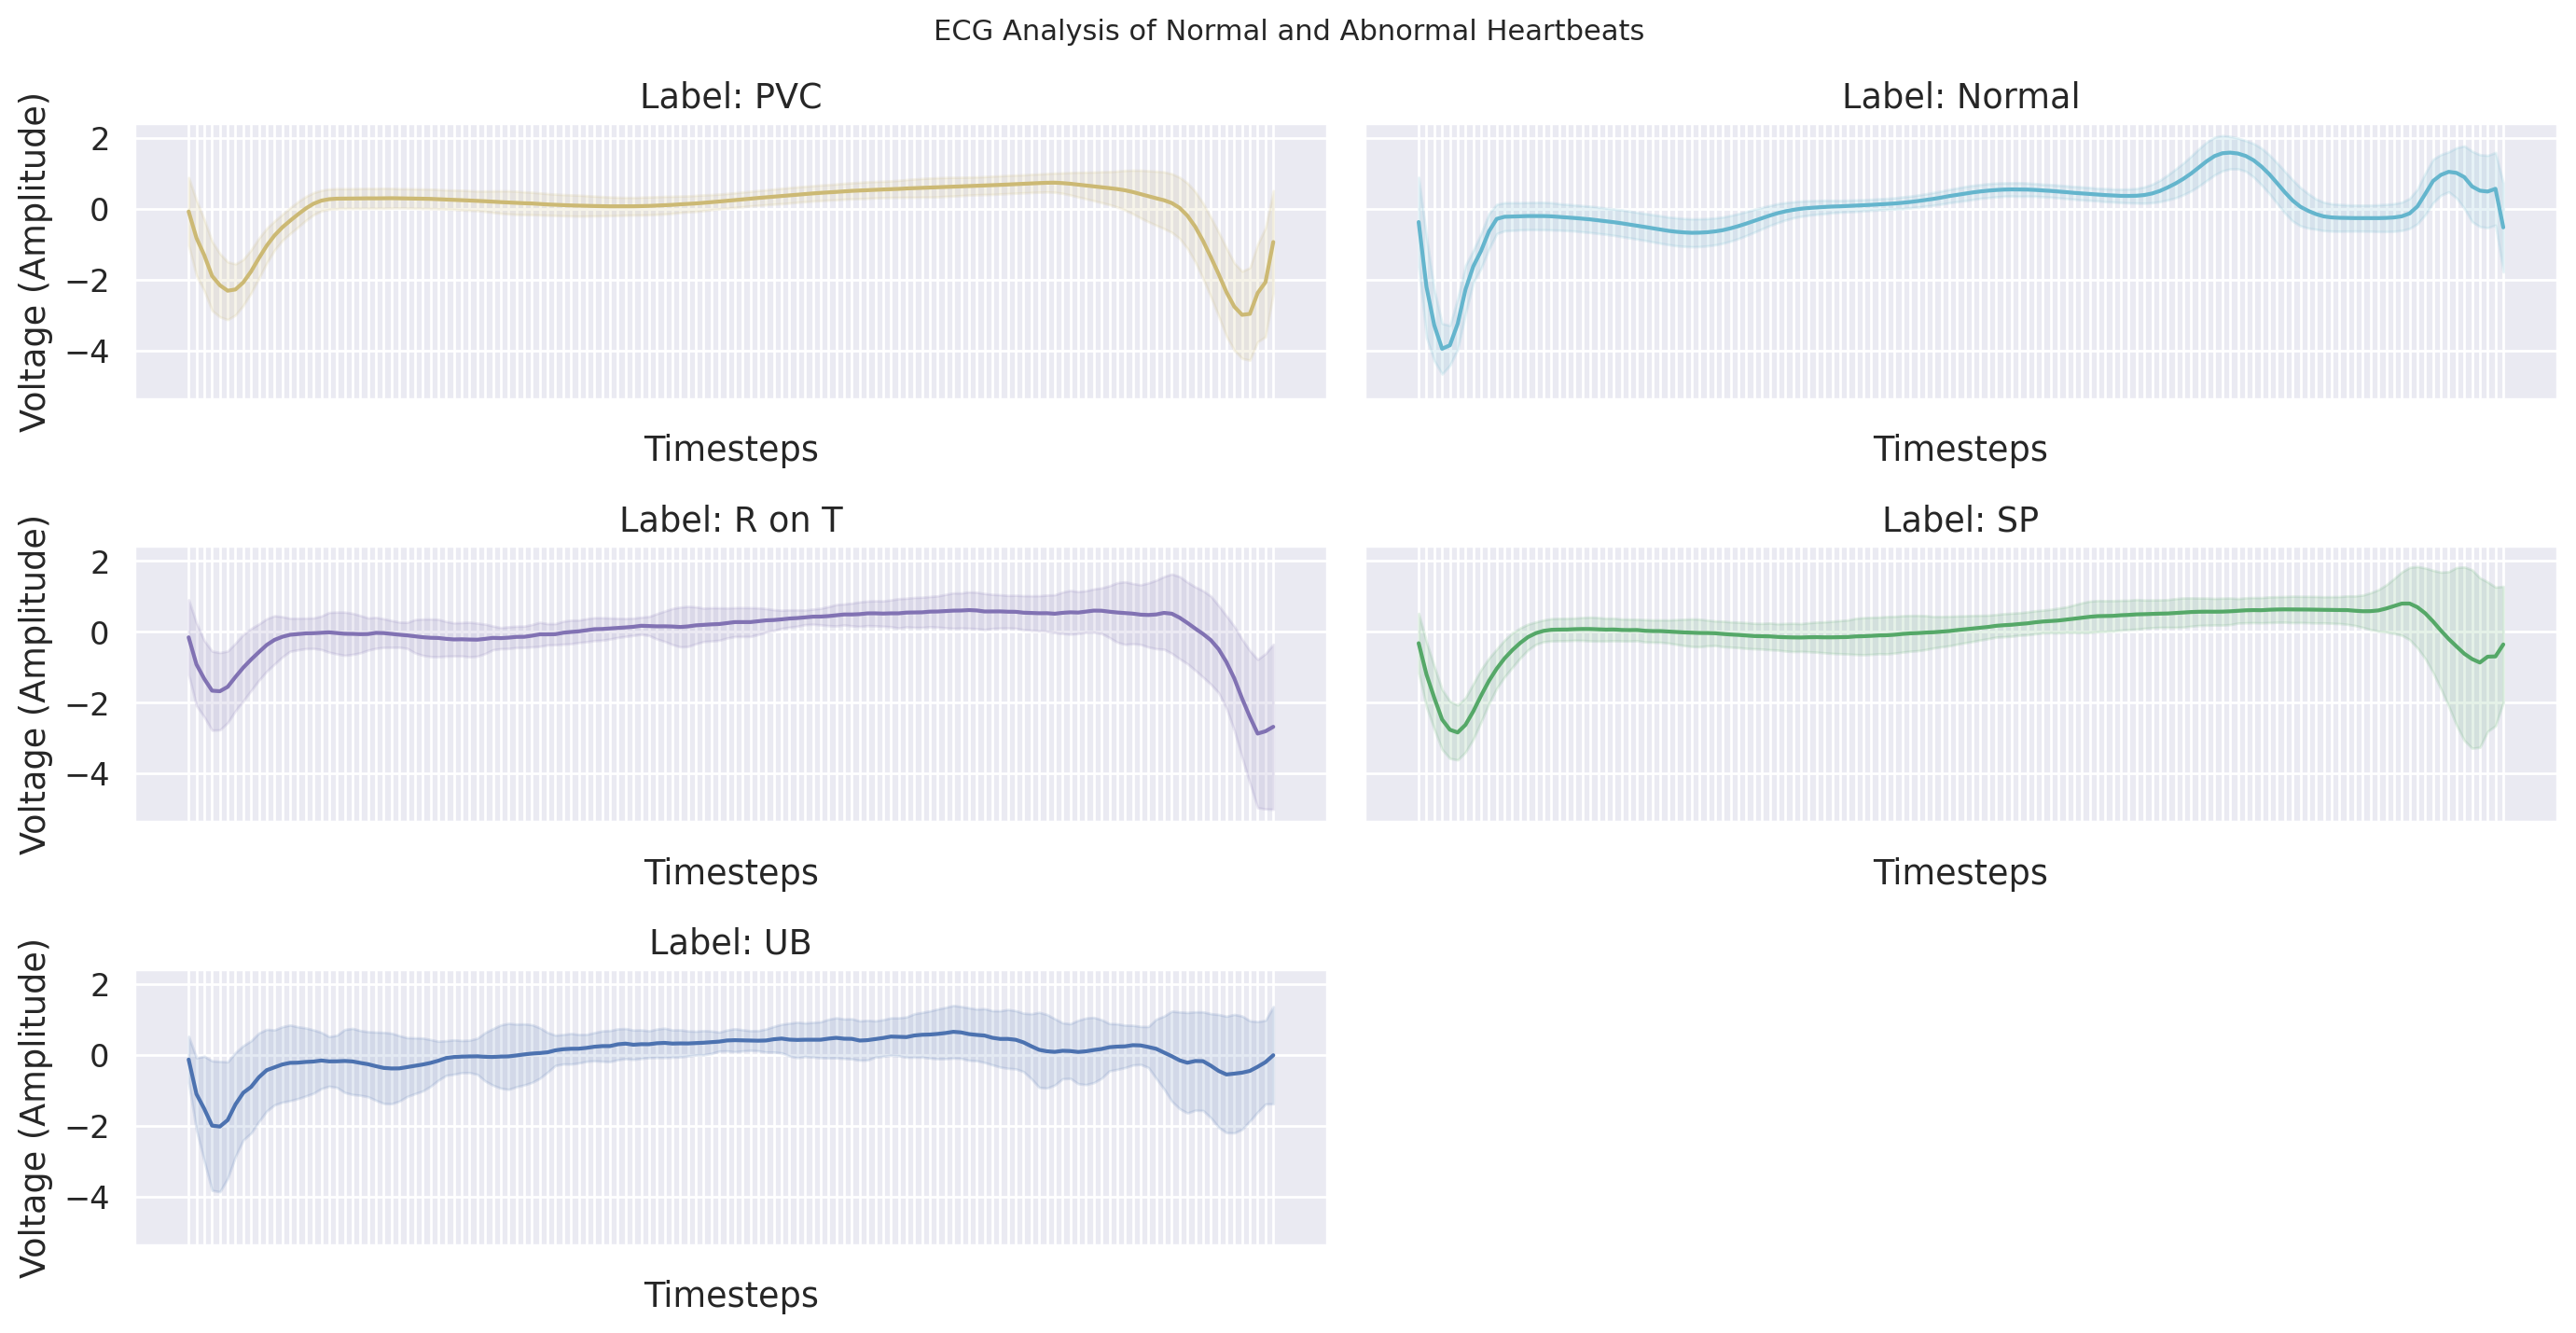

In [21]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=(len(unique_labels) + 1) // 2,
                         ncols=2,
                         sharey=True,
                         figsize=(14, 7))

# Define colors for the plots
colors = ['y', 'c', 'm', 'g', 'b', 'r']

# Plot each time series on a separate subplot
for ax_index, label in enumerate(unique_labels):
    ax = axes.flat[ax_index]
    plot_time_series(label, df, ax, colors[ax_index])

# Remove any unused subplots
if len(unique_labels) % 2 != 0:
    fig.delaxes(axes.flat[-1])

# Adjust layout and add a supertitle
fig.tight_layout()
fig.suptitle("ECG Analysis of Normal and Abnormal Heartbeats", fontsize=11, y=1.02)

# Display the plot
plt.show()

## Data Preparation

In [60]:
# Filter the DataFrame for normal data (label == 1) and drop the 'label' column
normal_data_df = df[df["label"] == 1].drop(labels="label", axis=1)

# Reset the index of the DataFrame
normal_data_df = normal_data_df.reset_index(drop=True)

# Display the first few rows of the DataFrame
print(normal_data_df.head())

# Print the shape of the DataFrame
print(normal_data_df.shape)

       att1      att2      att3      att4      att5      att6      att7  \
0 -3.177740 -4.763415 -4.591574 -4.433321 -3.823596 -2.358058 -1.154292   
1  1.886501  0.281386 -1.761107 -2.814009 -3.900076 -4.109113 -2.851389   
2  0.592081 -1.431191 -3.290827 -4.519046 -4.218367 -3.098228 -2.090225   
3 -1.840113 -4.168868 -4.117232 -4.442089 -3.675157 -2.379260 -1.803782   
4  1.293481 -0.469012 -2.250529 -3.958828 -4.517312 -3.828765 -2.759456   

       att8      att9     att10  ...    att131    att132    att133    att134  \
0 -0.957346 -0.139893  0.262132  ...  0.684491  0.634664  0.697819  0.650769   
1 -1.964215 -1.818925 -0.987048  ... -0.217876 -0.201902  0.354440  0.863455   
2 -1.706184 -1.280887 -0.471186  ...  1.139207  1.322938  1.038771  1.027637   
3 -1.563010 -0.769083 -0.413192  ...  0.329834  1.006195  1.177394  1.096236   
4 -1.767743 -1.570235 -0.994481  ...  1.450293  1.669094  2.118198  2.364729   

     att135    att136    att137    att138    att139    att140  
0  0

In [61]:
# Filter the DataFrame for anomaly data (label > 1) and drop the 'label' column
anomaly_data_df = df[df["label"] > 1].drop(labels="label", axis=1)

# Reset the index of the DataFrame
anomaly_data_df = anomaly_data_df.reset_index(drop=True)

# Display the first few rows of the DataFrame
print(anomaly_data_df.head())

# Print the shape of the DataFrame
print(anomaly_data_df.shape)

       att1      att2      att3      att4      att5      att6      att7  \
0  0.095953  0.176663  0.202666  0.130480  0.053099  0.054928  0.096500   
1  1.262039  0.252945 -0.772889 -1.661869 -2.407388 -2.785979 -2.800158   
2 -0.054996 -0.509445 -0.852320 -1.518126 -1.817344 -1.917368 -2.082339   
3 -0.942292 -1.414627 -1.762106 -2.049621 -2.349246 -2.548837 -2.429901   
4 -0.023435 -1.480080 -1.906637 -2.265917 -2.326845 -2.218670 -1.845043   

       att8      att9     att10  ...    att131    att132    att133    att134  \
0  0.115644  0.131840  0.179107  ... -2.418948 -2.897533 -3.419289 -3.995034   
1 -2.678961 -2.453753 -2.080578  ... -2.659032 -2.953539 -3.431749 -3.508566   
2 -2.097093 -2.004087 -1.844955  ... -1.636948 -2.113786 -2.808378 -3.395283   
3 -2.109827 -1.670025 -1.113154  ...  2.102585  1.846028  1.467805  1.243205   
4 -1.353444 -1.028540 -0.945153  ... -1.147818 -1.798436 -2.268472 -2.554459   

     att135    att136    att137    att138    att139    att140  
0 -4

In [62]:
def create_datasets(dataframe_df):
    # Convert DataFrame to a list of sequences (each sequence is a list of floats)
    sequences = dataframe_df.astype(np.float32).to_numpy().tolist()
    
    # Convert each sequence to a PyTorch tensor and add an extra dimension
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    
    # Stack all tensors to get a tensor of shape (n_seq, seq_len, n_features)
    stacked_dataset = torch.stack(dataset)
    
    # Get the dimensions of the stacked tensor
    n_seq, seq_len, n_features = stacked_dataset.shape
    
    return dataset, seq_len, n_features

In [63]:
# Split normal data into training and validation sets
training_df, validation_df = train_test_split(normal_data_df, test_size=0.2, random_state=42)

# Further split validation data into validation and test sets
validation_df, test_df = train_test_split(validation_df, test_size=0.4, random_state=42)

# Create datasets from the split data
dataset_training, _, _ = create_datasets(training_df)
dataset_validation, _, _ = create_datasets(validation_df)
dataset_test, sequence_length, n_features = create_datasets(test_df)
dataset_anomaly, _, _ = create_datasets(anomaly_data_df)

# Print sample dimensions
print("Sample dimension:", sequence_length, n_features)

Sample dimension: 140 1


In [64]:
def normalization_dist(data):
    # Convert the list of tensors to a single tensor and remove the last dimension
    df = pd.DataFrame(torch.stack(data).squeeze(2))
    
    # Normalize the DataFrame using L2 normalization
    df = torch.tensor(normalize(df, norm='l2')).unsqueeze(2)
    
    return df

In [65]:
# Normalize the training dataset
dataset_training = normalization_dist(dataset_training)

# Normalize the validation dataset
dataset_validation = normalization_dist(dataset_validation)

# Normalize the test dataset
dataset_test = normalization_dist(dataset_test)

# Normalize the anomaly dataset
dataset_anomaly = normalization_dist(dataset_anomaly)


## Model Implementation

In [39]:
class Encoder(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, embedding_dim=64):
        super(Encoder, self).__init__()
        self.sequence_length, self.n_features = sequence_length, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(input_size=self.n_features,
                            hidden_size=self.hidden_dim,
                            num_layers=n_layers,
                            batch_first=True)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.1)

        self.rnn2 = nn.LSTM(input_size=self.hidden_dim,
                            hidden_size=self.embedding_dim,
                            num_layers=n_layers,
                            batch_first=True)

    def forward(self, x):
        x = x.reshape((1, self.sequence_length, self.n_features))
        x, (_,_) = self.rnn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))

class Decoder(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, input_dim=64):
        super(Decoder, self).__init__()
        self.sequence_length, self.input_dim = sequence_length, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.input_dim,
                            num_layers=n_layers,
                            batch_first=True)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.1)

        self.rnn2 = nn.LSTM(input_size=self.input_dim,
                            hidden_size=self.hidden_dim,
                            num_layers=n_layers,
                            batch_first=True)

        self.output_layer = nn.Linear(self.hidden_dim, self.n_features)

    def forward(self, x):
        x = x.repeat(self.sequence_length, self.n_features)
        x = x.reshape((self.n_features, self.sequence_length, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.sequence_length, self.hidden_dim))
        return self.output_layer(x)

class LSTMAE(nn.Module):
    def __init__(self, sequence_length, n_features, n_layers=1, embedding_dim=64):
        super(LSTMAE, self).__init__()
        self.encoder = Encoder(sequence_length=sequence_length, n_features=n_features, n_layers=1, embedding_dim=embedding_dim)
        self.decoder = Decoder(sequence_length=sequence_length, n_features=n_features, n_layers=1, input_dim=embedding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Train and Fine-tuning

In [40]:
# Hyperparameters configuration
hyperparameters = {
    "lr": 1e-3,                 # Learning rate
    "n_epochs": 150,            # Number of epochs
    "n_layers": 3,              # Number of LSTM layers
    "embedding_dim": 64,        # LSTM embedding dimension
    "patience": 20              # Early stopping patience
}

In [41]:
# Initialize the LSTMAE model with hyperparameters
model = LSTMAE(
    sequence_length=sequence_length, 
    n_features=n_features,
    n_layers=hyperparameters["n_layers"], 
    embedding_dim=hyperparameters["embedding_dim"]
)

# Move the model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

LSTMAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [42]:
def train_model(model, train_dataset, val_dataset, hyperparameters):
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=hyperparameters["lr"],
        amsgrad=True
    )
    criterion = nn.L1Loss(reduction='sum').to(device)

    # Initialize history, best model weights, and early stopping parameters
    history = {'train': [], 'val': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience = hyperparameters["patience"]
    early_stop = 0

    for epoch in tqdm(range(1, hyperparameters["n_epochs"] + 1)):
        # Training phase
        model.train()
        train_losses = []
        for seq_true in train_dataset:
            optimizer.zero_grad()
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        # Validation phase
        val_losses = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        # Calculate and record losses
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)

        # Check for improvement and implement early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop = 0
        else:
            early_stop += 1
            if early_stop >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        # Print loss information
        print(f'Epoch {epoch}: train loss {train_loss:.4f} val loss {val_loss:.4f}')

    # Load best model weights and return
    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [43]:
# Train the model and obtain the trained model along with the training history
model, history = train_model(model, dataset_training, dataset_validation, hyperparameters)

  1%|          | 1/150 [00:28<1:10:36, 28.44s/it]

Epoch 1: train loss 5.3404 val loss 5.0131


  1%|▏         | 2/150 [00:59<1:13:41, 29.88s/it]

Epoch 2: train loss 4.3811 val loss 3.6510


  2%|▏         | 3/150 [01:28<1:12:23, 29.55s/it]

Epoch 3: train loss 3.7529 val loss 3.5039


  3%|▎         | 4/150 [02:00<1:14:23, 30.57s/it]

Epoch 4: train loss 3.6534 val loss 3.6469


  3%|▎         | 5/150 [02:35<1:17:20, 32.00s/it]

Epoch 5: train loss 3.5856 val loss 3.4852


  4%|▍         | 6/150 [03:05<1:15:46, 31.57s/it]

Epoch 6: train loss 3.5284 val loss 3.2197


  5%|▍         | 7/150 [03:36<1:14:12, 31.14s/it]

Epoch 7: train loss 3.4119 val loss 3.0496


  5%|▌         | 8/150 [04:02<1:10:01, 29.59s/it]

Epoch 8: train loss 3.1060 val loss 2.8423


  6%|▌         | 9/150 [04:26<1:05:12, 27.75s/it]

Epoch 9: train loss 2.9172 val loss 2.7787


  7%|▋         | 10/150 [04:53<1:04:21, 27.58s/it]

Epoch 10: train loss 2.6913 val loss 2.4477


  7%|▋         | 11/150 [05:20<1:03:50, 27.56s/it]

Epoch 11: train loss 2.4927 val loss 2.2223


  8%|▊         | 12/150 [05:50<1:04:30, 28.05s/it]

Epoch 12: train loss 2.3289 val loss 2.3871


  9%|▊         | 13/150 [06:13<1:01:13, 26.82s/it]

Epoch 13: train loss 2.2141 val loss 2.0006


  9%|▉         | 14/150 [06:40<1:00:35, 26.73s/it]

Epoch 14: train loss 2.1469 val loss 2.2444


 10%|█         | 15/150 [07:11<1:02:55, 27.97s/it]

Epoch 15: train loss 2.0484 val loss 1.9668


 11%|█         | 16/150 [07:41<1:03:54, 28.62s/it]

Epoch 16: train loss 2.0187 val loss 1.8385


 11%|█▏        | 17/150 [08:19<1:09:32, 31.37s/it]

Epoch 17: train loss 2.0601 val loss 1.9271


 12%|█▏        | 18/150 [08:45<1:05:46, 29.90s/it]

Epoch 18: train loss 1.9432 val loss 1.6689


 13%|█▎        | 19/150 [09:12<1:03:05, 28.90s/it]

Epoch 19: train loss 1.8716 val loss 1.8162


 13%|█▎        | 20/150 [09:43<1:03:54, 29.49s/it]

Epoch 20: train loss 1.8421 val loss 1.7129


 14%|█▍        | 21/150 [10:13<1:03:38, 29.60s/it]

Epoch 21: train loss 1.7935 val loss 1.5590


 15%|█▍        | 22/150 [10:40<1:01:50, 28.99s/it]

Epoch 22: train loss 1.7623 val loss 1.5808


 15%|█▌        | 23/150 [11:12<1:03:15, 29.88s/it]

Epoch 23: train loss 1.6986 val loss 1.9288


 16%|█▌        | 24/150 [11:39<1:00:51, 28.98s/it]

Epoch 24: train loss 1.6779 val loss 1.6739


 17%|█▋        | 25/150 [12:07<59:36, 28.62s/it]  

Epoch 25: train loss 1.6755 val loss 1.8311


 17%|█▋        | 26/150 [12:43<1:03:43, 30.83s/it]

Epoch 26: train loss 1.6259 val loss 1.5261


 18%|█▊        | 27/150 [13:15<1:04:23, 31.41s/it]

Epoch 27: train loss 1.6140 val loss 1.5750


 19%|█▊        | 28/150 [13:45<1:02:41, 30.83s/it]

Epoch 28: train loss 1.5938 val loss 1.4484


 19%|█▉        | 29/150 [14:13<1:00:20, 29.92s/it]

Epoch 29: train loss 1.5704 val loss 1.5912


 20%|██        | 30/150 [14:37<56:36, 28.30s/it]  

Epoch 30: train loss 1.5657 val loss 1.5801


 21%|██        | 31/150 [15:03<54:20, 27.40s/it]

Epoch 31: train loss 1.5563 val loss 1.6406


 21%|██▏       | 32/150 [15:30<53:55, 27.42s/it]

Epoch 32: train loss 1.5105 val loss 1.3776


 22%|██▏       | 33/150 [15:55<51:46, 26.55s/it]

Epoch 33: train loss 1.5127 val loss 1.4350


 23%|██▎       | 34/150 [16:21<51:22, 26.57s/it]

Epoch 34: train loss 1.5152 val loss 1.4095


 23%|██▎       | 35/150 [16:48<50:54, 26.56s/it]

Epoch 35: train loss 1.4678 val loss 1.3311


 24%|██▍       | 36/150 [17:13<50:01, 26.33s/it]

Epoch 36: train loss 1.4607 val loss 1.3137


 25%|██▍       | 37/150 [17:38<48:47, 25.91s/it]

Epoch 37: train loss 1.4506 val loss 1.4048


 25%|██▌       | 38/150 [18:12<52:38, 28.20s/it]

Epoch 38: train loss 1.4198 val loss 1.6847


 26%|██▌       | 39/150 [18:41<52:45, 28.52s/it]

Epoch 39: train loss 1.3929 val loss 1.3279


 27%|██▋       | 40/150 [19:07<50:42, 27.66s/it]

Epoch 40: train loss 1.3863 val loss 1.2032


 27%|██▋       | 41/150 [19:31<48:04, 26.47s/it]

Epoch 41: train loss 1.3736 val loss 1.3965


 28%|██▊       | 42/150 [19:54<46:15, 25.70s/it]

Epoch 42: train loss 1.3427 val loss 1.2413


 29%|██▊       | 43/150 [20:20<45:48, 25.69s/it]

Epoch 43: train loss 1.3509 val loss 1.9298


 29%|██▉       | 44/150 [20:47<45:59, 26.04s/it]

Epoch 44: train loss 1.3409 val loss 1.3902


 30%|███       | 45/150 [21:10<43:51, 25.07s/it]

Epoch 45: train loss 1.3314 val loss 1.5777


 31%|███       | 46/150 [21:32<42:02, 24.26s/it]

Epoch 46: train loss 1.3075 val loss 1.2914


 31%|███▏      | 47/150 [21:59<43:06, 25.11s/it]

Epoch 47: train loss 1.2862 val loss 1.4747


 32%|███▏      | 48/150 [22:24<42:15, 24.86s/it]

Epoch 48: train loss 1.2963 val loss 1.2579


 33%|███▎      | 49/150 [22:46<40:47, 24.23s/it]

Epoch 49: train loss 1.2709 val loss 1.1099


 33%|███▎      | 50/150 [23:14<41:58, 25.18s/it]

Epoch 50: train loss 1.2869 val loss 1.2561


 34%|███▍      | 51/150 [23:41<42:25, 25.71s/it]

Epoch 51: train loss 1.2651 val loss 1.1525


 35%|███▍      | 52/150 [24:07<42:20, 25.92s/it]

Epoch 52: train loss 1.2448 val loss 1.2818


 35%|███▌      | 53/150 [24:35<42:41, 26.41s/it]

Epoch 53: train loss 1.2548 val loss 1.3160


 36%|███▌      | 54/150 [25:00<41:42, 26.07s/it]

Epoch 54: train loss 1.2497 val loss 1.2669


 37%|███▋      | 55/150 [25:24<40:28, 25.56s/it]

Epoch 55: train loss 1.2468 val loss 1.1011


 37%|███▋      | 56/150 [25:48<39:04, 24.94s/it]

Epoch 56: train loss 1.2302 val loss 1.2520


 38%|███▊      | 57/150 [26:11<37:57, 24.48s/it]

Epoch 57: train loss 1.2035 val loss 1.2339


 39%|███▊      | 58/150 [26:39<39:01, 25.45s/it]

Epoch 58: train loss 1.2114 val loss 1.1373


 39%|███▉      | 59/150 [27:04<38:26, 25.34s/it]

Epoch 59: train loss 1.2179 val loss 1.1242


 40%|████      | 60/150 [27:28<37:12, 24.81s/it]

Epoch 60: train loss 1.1944 val loss 1.3191


 41%|████      | 61/150 [27:54<37:20, 25.17s/it]

Epoch 61: train loss 1.1922 val loss 1.4443


 41%|████▏     | 62/150 [28:17<36:04, 24.59s/it]

Epoch 62: train loss 1.1830 val loss 1.1312


 42%|████▏     | 63/150 [28:41<35:27, 24.45s/it]

Epoch 63: train loss 1.1873 val loss 1.3963


 43%|████▎     | 64/150 [29:06<35:18, 24.64s/it]

Epoch 64: train loss 1.1690 val loss 1.3236


 43%|████▎     | 65/150 [29:31<35:12, 24.85s/it]

Epoch 65: train loss 1.1652 val loss 1.0681


 44%|████▍     | 66/150 [29:57<35:19, 25.24s/it]

Epoch 66: train loss 1.1645 val loss 1.0701


 45%|████▍     | 67/150 [30:25<35:49, 25.90s/it]

Epoch 67: train loss 1.1381 val loss 1.0499


 45%|████▌     | 68/150 [30:49<34:37, 25.34s/it]

Epoch 68: train loss 1.1334 val loss 1.1217


 46%|████▌     | 69/150 [31:13<33:34, 24.87s/it]

Epoch 69: train loss 1.1282 val loss 1.0577


 47%|████▋     | 70/150 [31:39<33:52, 25.41s/it]

Epoch 70: train loss 1.1204 val loss 1.1363


 47%|████▋     | 71/150 [32:08<34:37, 26.30s/it]

Epoch 71: train loss 1.1188 val loss 1.0700


 48%|████▊     | 72/150 [32:35<34:23, 26.46s/it]

Epoch 72: train loss 1.1924 val loss 1.2161


 49%|████▊     | 73/150 [33:00<33:35, 26.17s/it]

Epoch 73: train loss 1.1207 val loss 1.1504


 49%|████▉     | 74/150 [33:25<32:42, 25.83s/it]

Epoch 74: train loss 1.0886 val loss 1.0011


 50%|█████     | 75/150 [33:50<32:00, 25.60s/it]

Epoch 75: train loss 1.0817 val loss 1.1719


 51%|█████     | 76/150 [34:16<31:36, 25.63s/it]

Epoch 76: train loss 1.0901 val loss 0.9864


 51%|█████▏    | 77/150 [34:40<30:43, 25.25s/it]

Epoch 77: train loss 1.0773 val loss 0.9815


 52%|█████▏    | 78/150 [35:06<30:36, 25.51s/it]

Epoch 78: train loss 1.0842 val loss 1.2698


 53%|█████▎    | 79/150 [35:32<30:24, 25.70s/it]

Epoch 79: train loss 1.0821 val loss 1.0254


 53%|█████▎    | 80/150 [35:59<30:08, 25.83s/it]

Epoch 80: train loss 1.0674 val loss 1.0177


 54%|█████▍    | 81/150 [36:24<29:27, 25.61s/it]

Epoch 81: train loss 1.0792 val loss 1.0392


 55%|█████▍    | 82/150 [36:51<29:43, 26.22s/it]

Epoch 82: train loss 1.0553 val loss 1.0858


 55%|█████▌    | 83/150 [37:18<29:26, 26.37s/it]

Epoch 83: train loss 1.0413 val loss 0.9221


 56%|█████▌    | 84/150 [37:44<28:45, 26.15s/it]

Epoch 84: train loss 1.0464 val loss 0.9310


 57%|█████▋    | 85/150 [38:07<27:14, 25.14s/it]

Epoch 85: train loss 1.0297 val loss 1.0530


 57%|█████▋    | 86/150 [38:34<27:33, 25.83s/it]

Epoch 86: train loss 1.0375 val loss 0.9766


 58%|█████▊    | 87/150 [39:01<27:33, 26.24s/it]

Epoch 87: train loss 1.0196 val loss 1.0506


 59%|█████▊    | 88/150 [39:24<25:58, 25.13s/it]

Epoch 88: train loss 1.0354 val loss 1.0225


 59%|█████▉    | 89/150 [39:50<25:46, 25.35s/it]

Epoch 89: train loss 1.0425 val loss 1.0381


 60%|██████    | 90/150 [40:17<26:01, 26.02s/it]

Epoch 90: train loss 1.0665 val loss 0.9665


 61%|██████    | 91/150 [40:41<24:58, 25.40s/it]

Epoch 91: train loss 1.0375 val loss 1.0295


 61%|██████▏   | 92/150 [41:06<24:31, 25.36s/it]

Epoch 92: train loss 1.0268 val loss 1.0146


 62%|██████▏   | 93/150 [41:31<23:52, 25.13s/it]

Epoch 93: train loss 1.0148 val loss 0.9928


 63%|██████▎   | 94/150 [41:55<23:09, 24.82s/it]

Epoch 94: train loss 1.0164 val loss 1.0126


 63%|██████▎   | 95/150 [42:20<22:47, 24.87s/it]

Epoch 95: train loss 1.0097 val loss 0.8967


 64%|██████▍   | 96/150 [42:44<22:03, 24.50s/it]

Epoch 96: train loss 1.0228 val loss 1.1693


 65%|██████▍   | 97/150 [43:09<21:58, 24.88s/it]

Epoch 97: train loss 0.9941 val loss 0.9731


 65%|██████▌   | 98/150 [43:33<21:19, 24.61s/it]

Epoch 98: train loss 1.0011 val loss 0.9590


 66%|██████▌   | 99/150 [43:56<20:27, 24.07s/it]

Epoch 99: train loss 0.9927 val loss 0.9792


 67%|██████▋   | 100/150 [44:21<20:19, 24.39s/it]

Epoch 100: train loss 0.9933 val loss 0.9311


 67%|██████▋   | 101/150 [44:47<20:14, 24.79s/it]

Epoch 101: train loss 0.9839 val loss 1.0580


 68%|██████▊   | 102/150 [45:10<19:27, 24.32s/it]

Epoch 102: train loss 0.9859 val loss 1.1276


 69%|██████▊   | 103/150 [45:33<18:42, 23.88s/it]

Epoch 103: train loss 0.9786 val loss 1.0496


 69%|██████▉   | 104/150 [45:57<18:20, 23.92s/it]

Epoch 104: train loss 0.9893 val loss 1.0277


 70%|███████   | 105/150 [46:21<17:52, 23.83s/it]

Epoch 105: train loss 0.9952 val loss 1.0487


 71%|███████   | 106/150 [46:44<17:22, 23.70s/it]

Epoch 106: train loss 0.9714 val loss 0.8964


 71%|███████▏  | 107/150 [47:09<17:18, 24.16s/it]

Epoch 107: train loss 0.9810 val loss 0.9916


 72%|███████▏  | 108/150 [47:36<17:26, 24.92s/it]

Epoch 108: train loss 0.9809 val loss 0.9857


 73%|███████▎  | 109/150 [48:04<17:32, 25.66s/it]

Epoch 109: train loss 0.9714 val loss 0.9026


 73%|███████▎  | 110/150 [48:30<17:12, 25.82s/it]

Epoch 110: train loss 0.9768 val loss 0.9164


 74%|███████▍  | 111/150 [48:56<16:47, 25.83s/it]

Epoch 111: train loss 0.9760 val loss 0.9153


 75%|███████▍  | 112/150 [49:22<16:30, 26.06s/it]

Epoch 112: train loss 0.9696 val loss 0.8965


 75%|███████▌  | 113/150 [49:50<16:18, 26.45s/it]

Epoch 113: train loss 0.9653 val loss 0.9286


 76%|███████▌  | 114/150 [50:12<15:14, 25.40s/it]

Epoch 114: train loss 0.9581 val loss 0.8948


 77%|███████▋  | 115/150 [50:39<15:00, 25.74s/it]

Epoch 115: train loss 0.9651 val loss 0.9406


 77%|███████▋  | 116/150 [51:06<14:45, 26.03s/it]

Epoch 116: train loss 0.9649 val loss 1.0354


 78%|███████▊  | 117/150 [51:31<14:12, 25.82s/it]

Epoch 117: train loss 0.9564 val loss 0.9249


 79%|███████▊  | 118/150 [51:55<13:33, 25.41s/it]

Epoch 118: train loss 0.9619 val loss 1.0598


 79%|███████▉  | 119/150 [52:22<13:17, 25.73s/it]

Epoch 119: train loss 0.9573 val loss 0.9080


 80%|████████  | 120/150 [52:49<13:05, 26.20s/it]

Epoch 120: train loss 0.9480 val loss 1.0613


 81%|████████  | 121/150 [53:14<12:29, 25.83s/it]

Epoch 121: train loss 0.9517 val loss 1.0514


 81%|████████▏ | 122/150 [53:43<12:25, 26.62s/it]

Epoch 122: train loss 0.9621 val loss 0.9048


 82%|████████▏ | 123/150 [54:11<12:09, 27.02s/it]

Epoch 123: train loss 0.9464 val loss 0.9047


 83%|████████▎ | 124/150 [54:35<11:18, 26.11s/it]

Epoch 124: train loss 0.9494 val loss 0.9893


 83%|████████▎ | 125/150 [54:58<10:31, 25.25s/it]

Epoch 125: train loss 0.9317 val loss 0.8649


 84%|████████▍ | 126/150 [55:22<10:00, 25.01s/it]

Epoch 126: train loss 0.9334 val loss 0.9064


 85%|████████▍ | 127/150 [55:46<09:27, 24.65s/it]

Epoch 127: train loss 0.9475 val loss 0.9240


 85%|████████▌ | 128/150 [56:10<08:55, 24.34s/it]

Epoch 128: train loss 0.9509 val loss 0.9101


 86%|████████▌ | 129/150 [56:33<08:25, 24.05s/it]

Epoch 129: train loss 0.9284 val loss 0.9608


 87%|████████▋ | 130/150 [56:56<07:55, 23.80s/it]

Epoch 130: train loss 0.9439 val loss 0.9598


 87%|████████▋ | 131/150 [57:20<07:30, 23.71s/it]

Epoch 131: train loss 0.9379 val loss 0.8786


 88%|████████▊ | 132/150 [57:44<07:07, 23.73s/it]

Epoch 132: train loss 0.9372 val loss 0.9355


 89%|████████▊ | 133/150 [58:07<06:42, 23.68s/it]

Epoch 133: train loss 0.9339 val loss 0.8705


 89%|████████▉ | 134/150 [58:32<06:22, 23.91s/it]

Epoch 134: train loss 0.9461 val loss 0.9142


 90%|█████████ | 135/150 [59:01<06:25, 25.67s/it]

Epoch 135: train loss 0.9412 val loss 1.0059


 91%|█████████ | 136/150 [59:29<06:07, 26.27s/it]

Epoch 136: train loss 0.9230 val loss 0.9163


 91%|█████████▏| 137/150 [59:52<05:30, 25.41s/it]

Epoch 137: train loss 0.9308 val loss 0.9189


 92%|█████████▏| 138/150 [1:00:16<04:57, 24.79s/it]

Epoch 138: train loss 0.9233 val loss 0.9312


 93%|█████████▎| 139/150 [1:00:40<04:29, 24.53s/it]

Epoch 139: train loss 0.9330 val loss 0.9830


 93%|█████████▎| 140/150 [1:01:03<04:02, 24.23s/it]

Epoch 140: train loss 0.9220 val loss 0.9721


 94%|█████████▍| 141/150 [1:01:27<03:36, 24.05s/it]

Epoch 141: train loss 0.9291 val loss 0.8692


 95%|█████████▍| 142/150 [1:01:50<03:10, 23.87s/it]

Epoch 142: train loss 0.9298 val loss 0.9619


 95%|█████████▌| 143/150 [1:02:15<02:48, 24.00s/it]

Epoch 143: train loss 0.9245 val loss 0.9550


 96%|█████████▌| 144/150 [1:02:39<02:25, 24.23s/it]

Epoch 144: train loss 0.9210 val loss 0.8783


 96%|█████████▌| 144/150 [1:03:13<02:38, 26.34s/it]

Early stopping at epoch 145


In [44]:
torch.save(model,
           Path("./models/model_lr_{}_layers_{}_embedding_{}.pth".format(hyperparameters["lr"],
                                                                         hyperparameters["n_layers"],
                                                                         hyperparameters["embedding_dim"])))

In [45]:
fig_path = Path("./assets/model_lr_{}_layers_{}_embedding_{}.png".format(hyperparameters["lr"],
                                                                         hyperparameters["n_layers"],
                                                                         hyperparameters["embedding_dim"]))

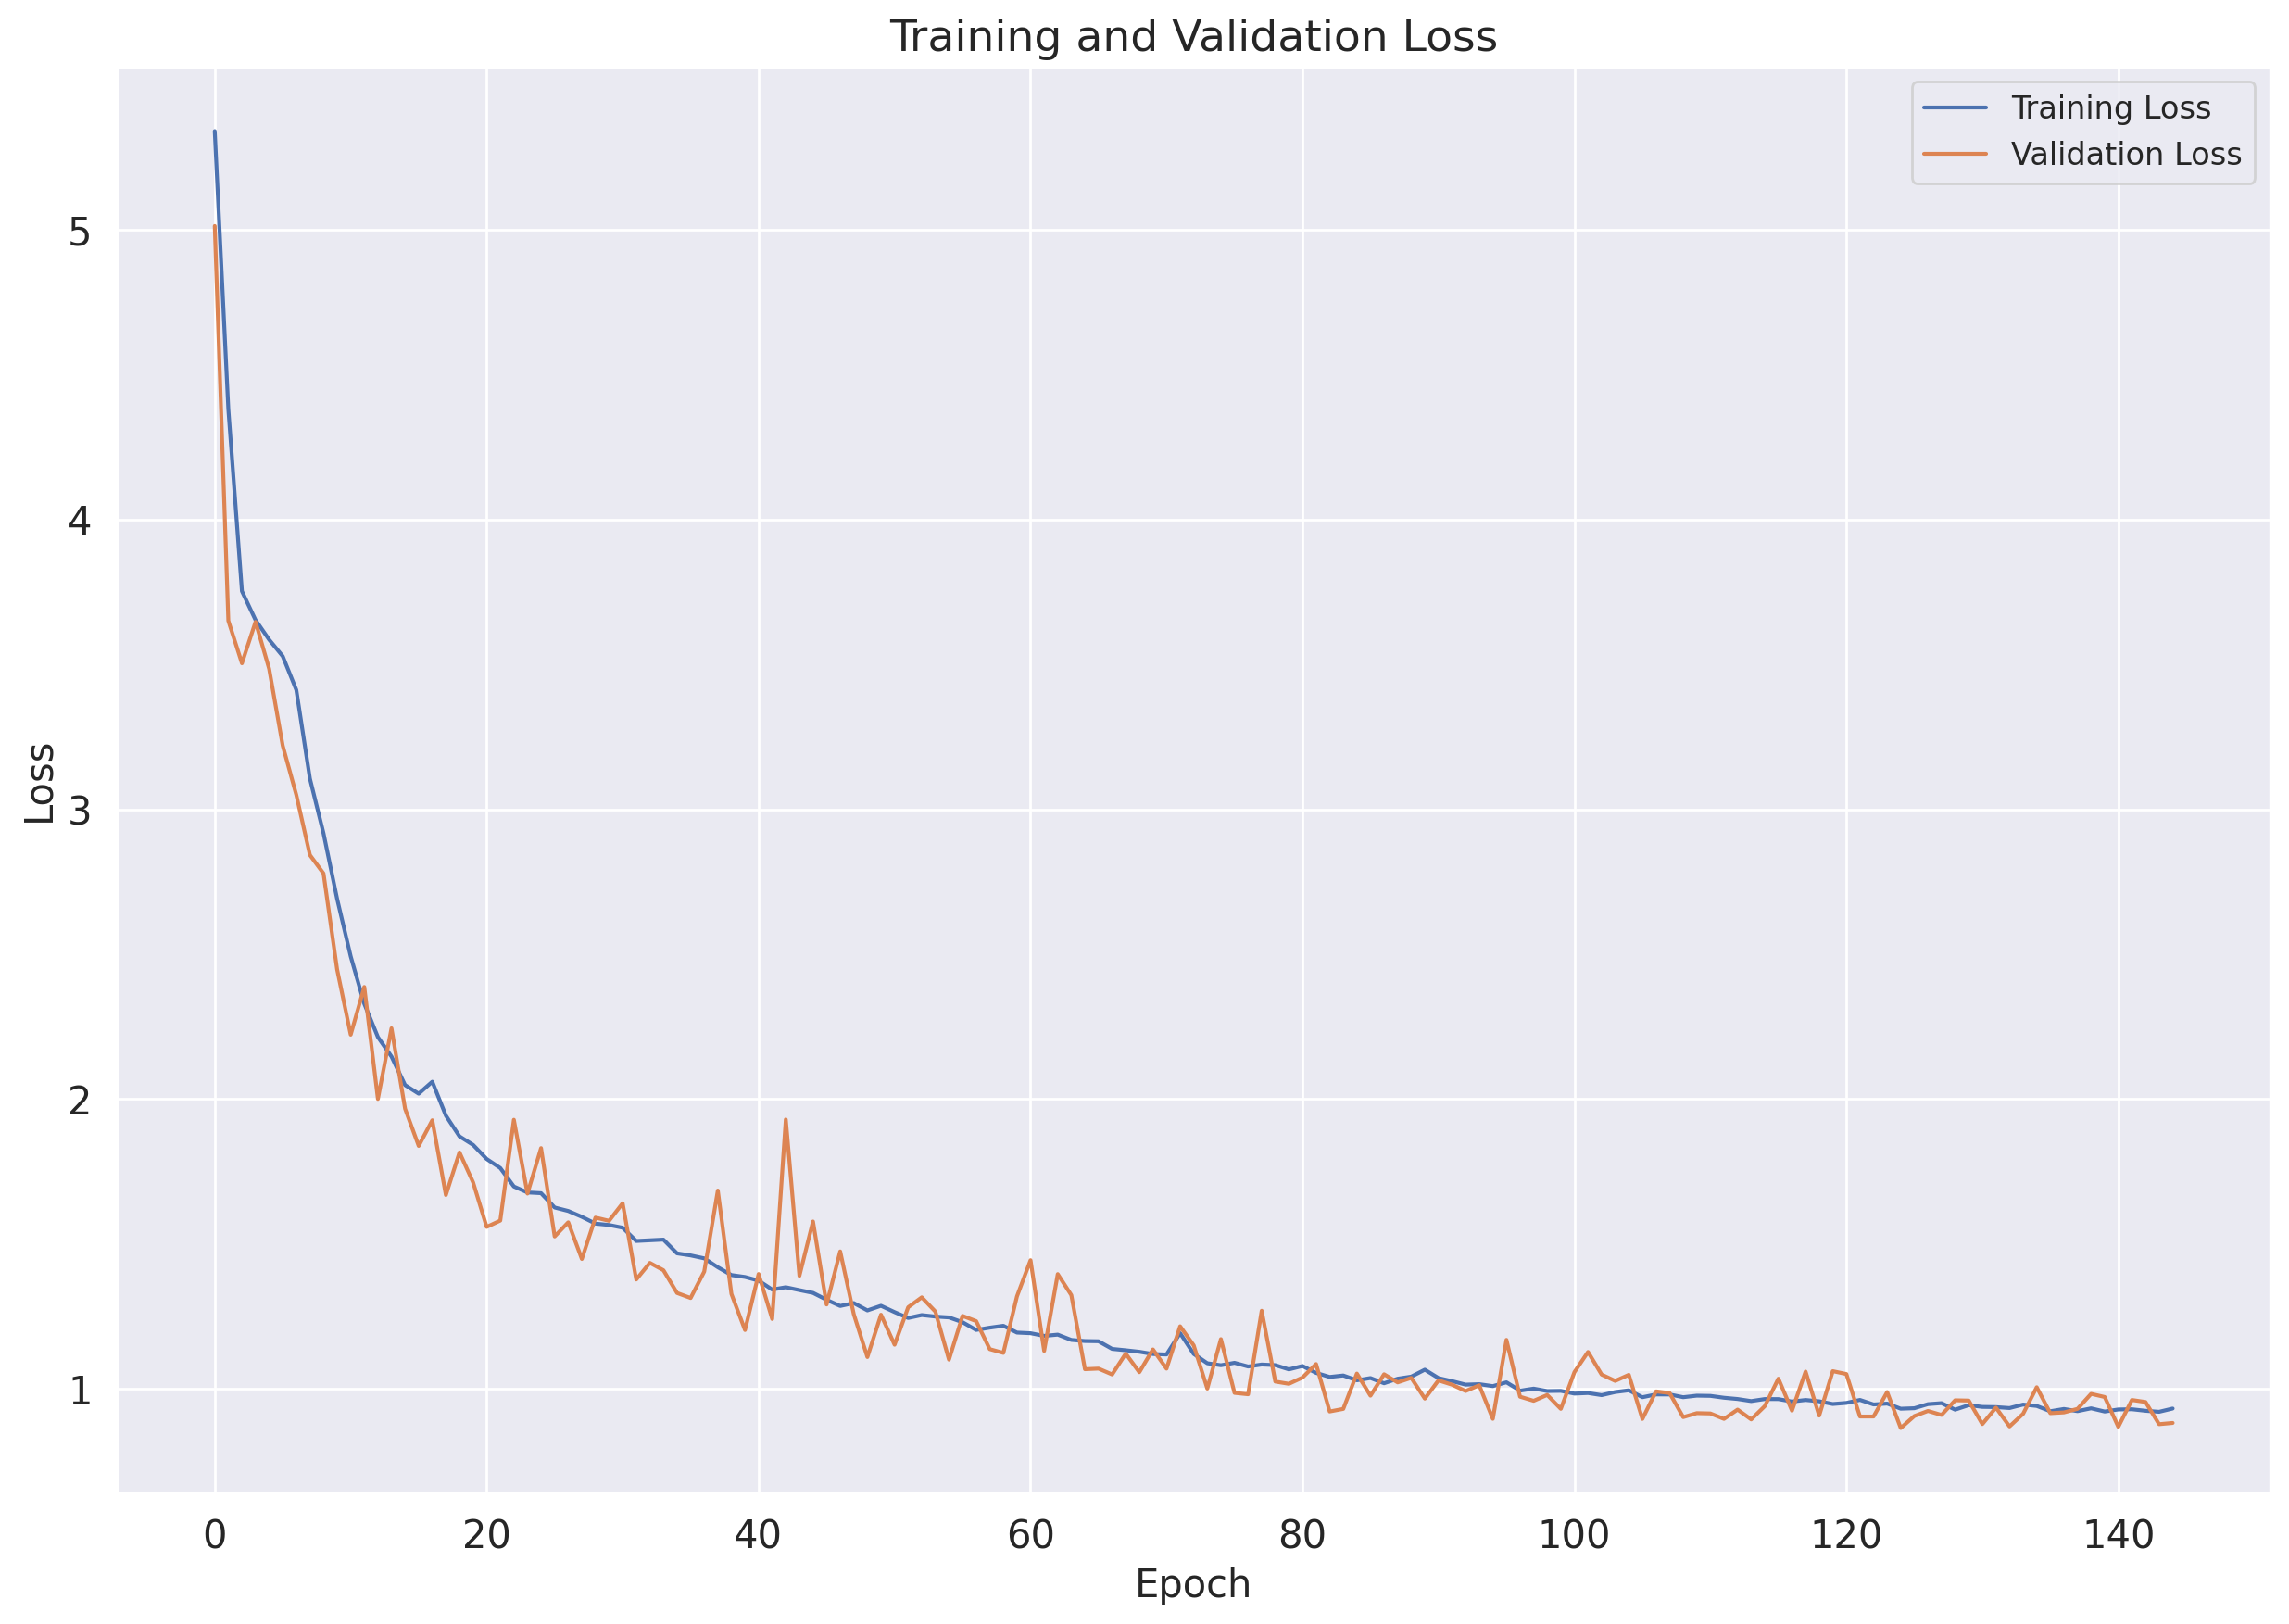

In [82]:
# Plot training and validation loss
plt.figure(figsize=(15, 10))  # Optional: adjust figure size
plt.plot(history['train'], label='Training Loss')
plt.plot(history['val'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=17)
plt.legend()
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fig_path)  # Save the plot to the specified path
plt.show()  # Display the plot

## Model Performance Evaluation

In [87]:
# Define the path to the saved model
path_to_the_model = Path("./models/model_lr_{}_layers_{}_embedding_{}.pth".format(
    hyperparameters["lr"],
    hyperparameters["n_layers"],
    hyperparameters["embedding_dim"]
))

# Load the model from the specified path
model = torch.load(path_to_the_model, map_location=torch.device(device))

# Move the model to the appropriate device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_152511/1722967814.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_to_the_model, map_location=torch.device(device))


LSTMAE(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.1, inplace=False)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

Data Sizes:
Training set: 2335
Validation set: 350
Test set: 234
Anomaly set: 2081


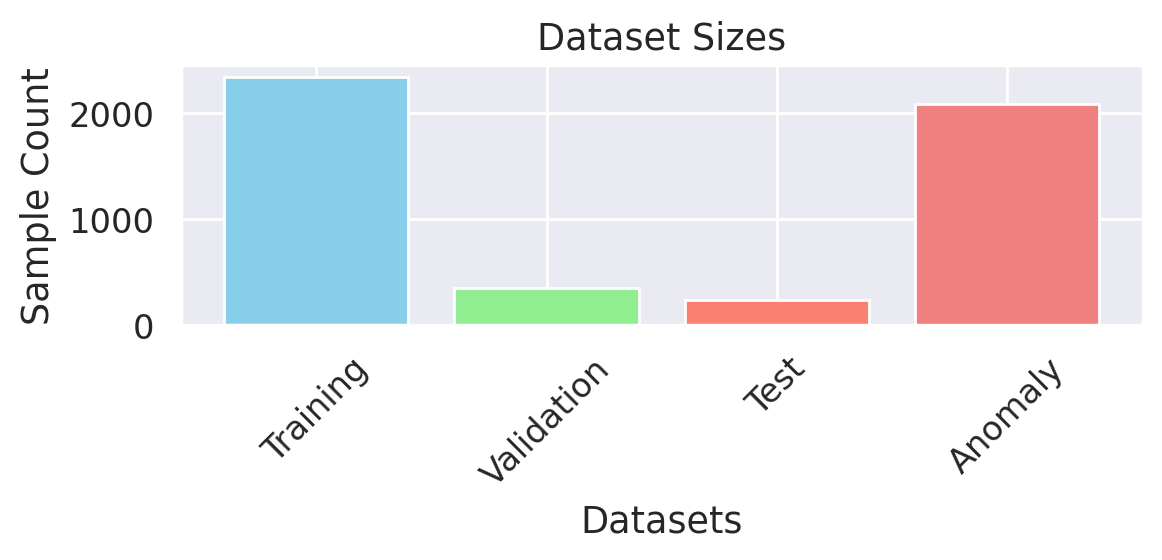

In [88]:
# Plotting data sizes
plt.figure(figsize=(6, 3))
plt.bar(['Training', 'Validation', 'Test', 'Anomaly'],
        [len(training_df), len(validation_df), len(test_df), len(anomaly_data_df)],
        color=['skyblue', 'lightgreen', 'salmon', 'lightcoral'])

plt.xlabel('Datasets')
plt.ylabel('Sample Count')
plt.title('Dataset Sizes')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping

# Printing data sizes
print(f'Data Sizes:\n'
      f'Training set: {len(training_df)}\n'
      f'Validation set: {len(validation_df)}\n'
      f'Test set: {len(test_df)}\n'
      f'Anomaly set: {len(anomaly_data_df)}')

plt.show()

In [89]:
def compute_metrics(model, dataset_normal, dataset_anomaly, device):
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    # Initialize lists for losses
    loss_n, loss_a = [], []

    # Compute losses for normal samples
    model.eval()
    with torch.no_grad():
        for sequence in tqdm(dataset_normal, desc='Normal samples'):
            sequence_true = sequence.to(device)
            sequence_pred = model(sequence_true)
            loss = criterion(sequence_pred, sequence_true)
            loss_n.append(sequence.squeeze(1).tolist() + [loss.item()])

        # Compute losses for anomaly samples
        for sequence in tqdm(dataset_anomaly, desc='Anomaly samples'):
            sequence_true = sequence.to(device)
            sequence_pred = model(sequence_true)
            loss = criterion(sequence_pred, sequence_true)
            loss_a.append(sequence.squeeze(1).tolist() + [loss.item()])

    # Create DataFrame for metrics
    normal_samples = np.concatenate((np.zeros((len(loss_n), 1)), np.array(loss_n)), axis=1)
    anomaly_samples = np.concatenate((np.ones((len(loss_a), 1)), np.array(loss_a)), axis=1)
    full_samples = np.vstack((normal_samples, anomaly_samples))
    df_samples = pd.DataFrame(full_samples, columns=['label'] + [f'feature_{i}' for i in range(full_samples.shape[1] - 2)] + ['loss'])
    
    # Compute precision-recall and F1 score
    precision, recall, thresholds_pr = precision_recall_curve(df_samples['label'], df_samples['loss'])
    pr = precision * recall
    p_r = precision + recall
    f1_scores = [2 * (pr_i / p_r_i) if p_r_i > 0 else 0 for pr_i, p_r_i in zip(pr, p_r)]

    # Determine the best threshold and metrics
    best_threshold_index = np.argmax(f1_scores)
    best_threshold = thresholds_pr[best_threshold_index]
    best_precision, best_recall = precision[best_threshold_index], recall[best_threshold_index]
    
    best_metrics = {
        'Best F1 Score': np.max(f1_scores),
        'Best Precision': best_precision,
        'Best Recall': best_recall,
        'Best Threshold': best_threshold
    }

    # Update DataFrame with predictions
    df_samples['pred'] = np.where(df_samples['loss'] < best_threshold, 0, 1)
    accuracy = np.mean(df_samples['label'] == df_samples['pred'])
    best_metrics['Accuracy'] = accuracy

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(df_samples['label'], df_samples['loss'])
    roc_auc = auc(fpr, tpr)

    # Plot PR curve and ROC curve
    plt.figure(figsize=(12, 5))

    # PR Curve
    plt.subplot(1, 2, 1)
    plt.plot(recall, precision, color='blue', label='PR Curve')
    plt.scatter(best_recall, best_precision, color='orange', label='Best PR (Max F1 Score)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return df_samples, best_metrics, loss_n, loss_a

Anomaly samples: 100%|██████████| 2081/2081 [00:06<00:00, 301.31it/s]


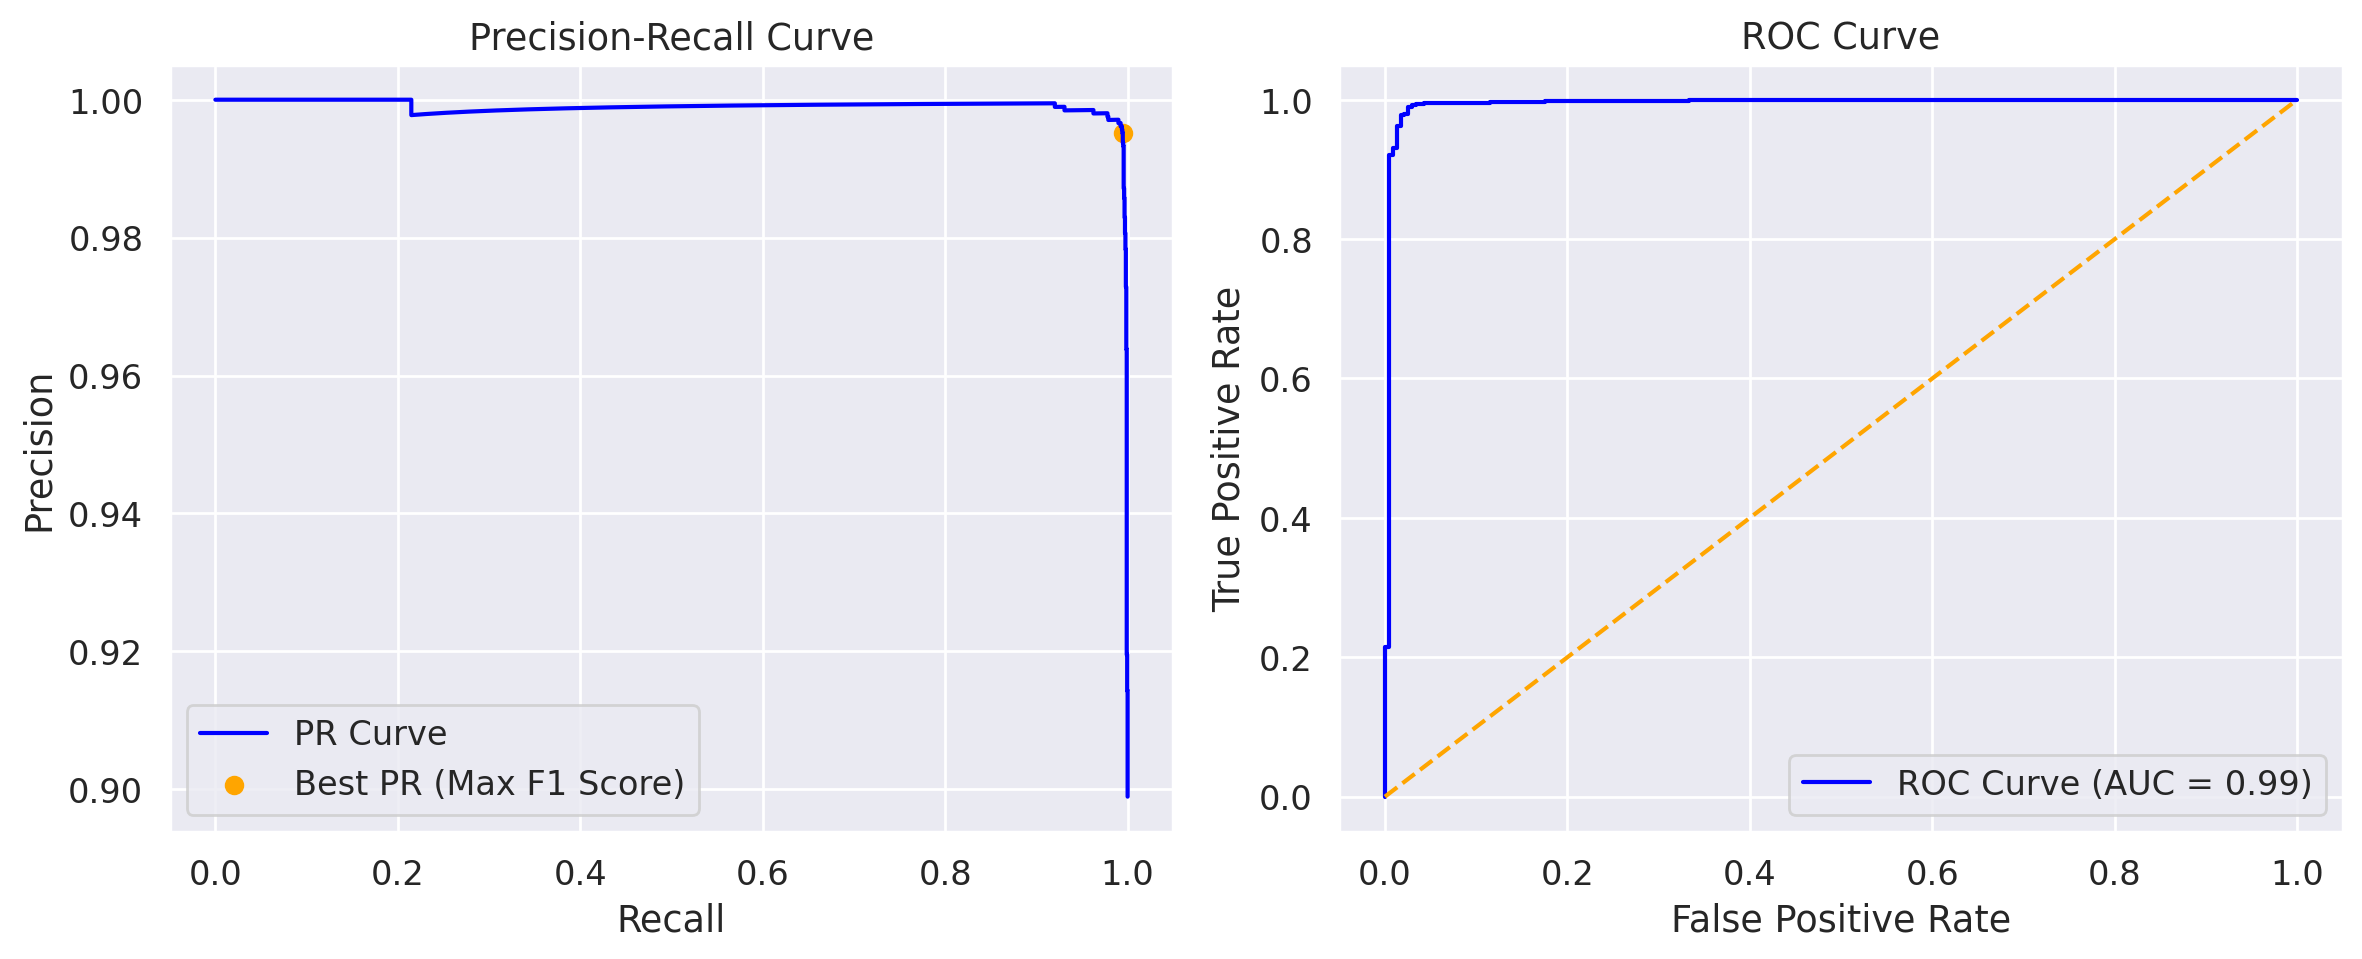

{'Best F1 Score': 0.9949531362653209,
 'Best Precision': 0.9951923076923077,
 'Best Recall': 0.9947140797693417,
 'Best Threshold': 1.7392997741699219,
 'Accuracy': 0.9909287257019438}

In [90]:
df_samples, best_metrics, loss_n, loss_a = compute_metrics(model=model,
                                                           dataset_normal=dataset_test,
                                                           dataset_anomaly=dataset_anomaly,
                                                           device=device)
best_metrics

## Visualizing results and decision threshold

In [91]:
features = np.arange(0, 140)  # Adjust to match your DataFrame's actual column indices

normal_samples = df_samples[df_samples.label==0].sample(8, random_state=42).astype(np.float32)
normal_samples = torch.tensor(normal_samples.iloc[:, features].values).unsqueeze(2)

anomaly_samples = df_samples[df_samples.label==1].sample(8, random_state=42).astype(np.float32)
anomaly_samples = torch.tensor(anomaly_samples.iloc[:, features].values).unsqueeze(2)


In [92]:
def plot_samples(samples, model, title, device='cpu'):
    samples_pred = []  # List to store predicted sequences
    criterion = nn.L1Loss(reduction='sum').to(device)  # Loss function
    loss_pred = []  # List to store reconstruction errors

    # Iterate over the samples to get predictions and calculate loss
    for i in samples:
        pred = model(i)  # Get the model's prediction
        samples_pred.append(pred)  # Append prediction to the list
        loss_pred.append(criterion(pred, i))  # Calculate and append loss

    # Convert tensors to lists for plotting
    samples_pred = torch.stack(samples_pred).squeeze(2).tolist()
    samples_truth = samples.squeeze(2).tolist()

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    
    # Plot each sample
    for ax, p, t, l in zip(axs.flatten(), samples_pred, samples_truth, loss_pred):
        ax.plot(np.arange(0, len(t)), t, color='tab:blue', label='True')  # Plot true values
        ax.plot(np.arange(0, len(p)), p, color='tab:orange', label='Prediction')  # Plot predicted values
        ax.set_title(f'Reconstruction Error: {round(l.item(), 3)}')  # Set title with error
        ax.set_xlabel('Time Step')  # Set x-axis label
        ax.set_ylabel('Voltage (Amplitude)')  # Set y-axis label
        ax.legend()  # Show legend

    plt.suptitle(title)  # Set the overall title of the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

    return loss_pred  # Return list of reconstruction errors


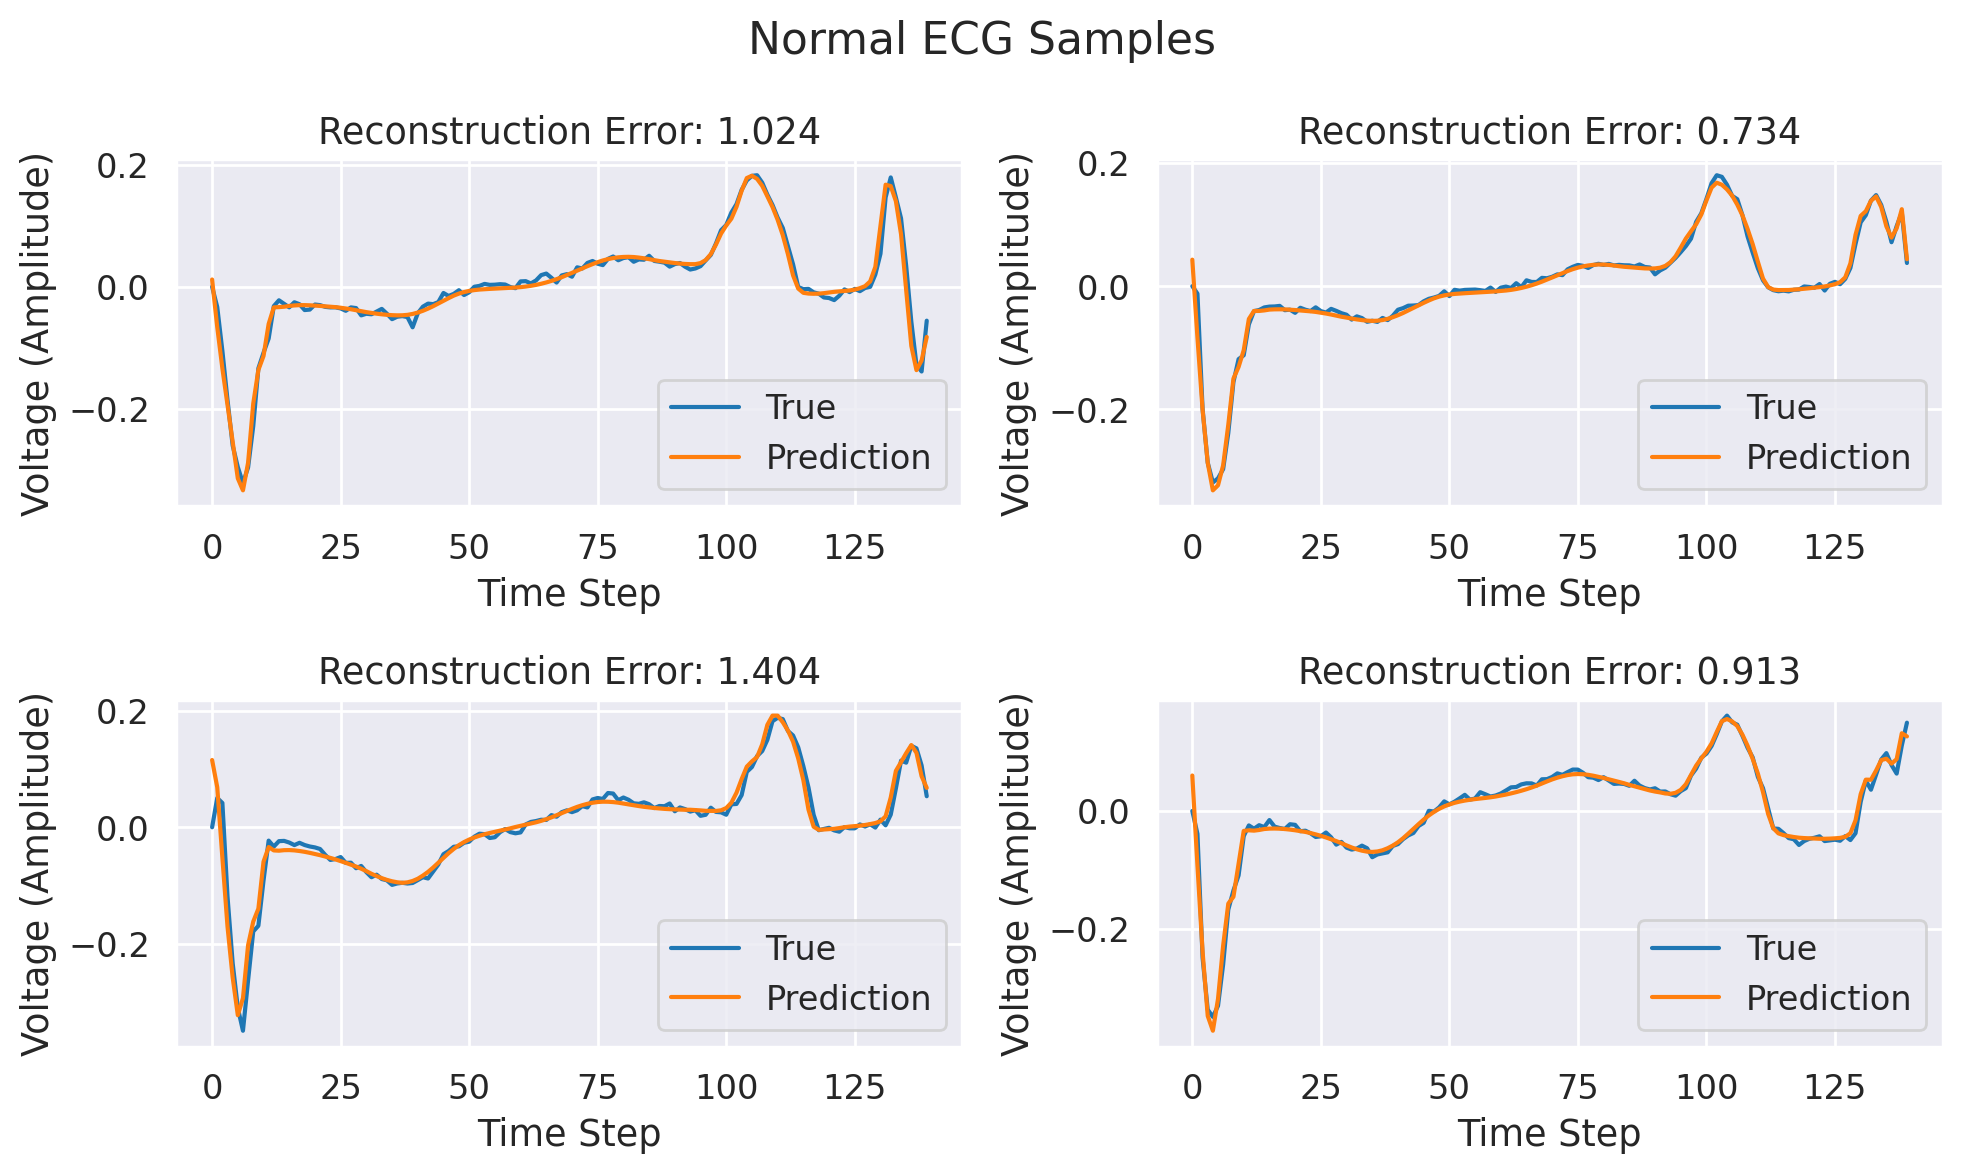

In [93]:
# Normal Samples
loss_pred_normal = plot_samples(normal_samples.to(device), model, title='Normal ECG Samples')

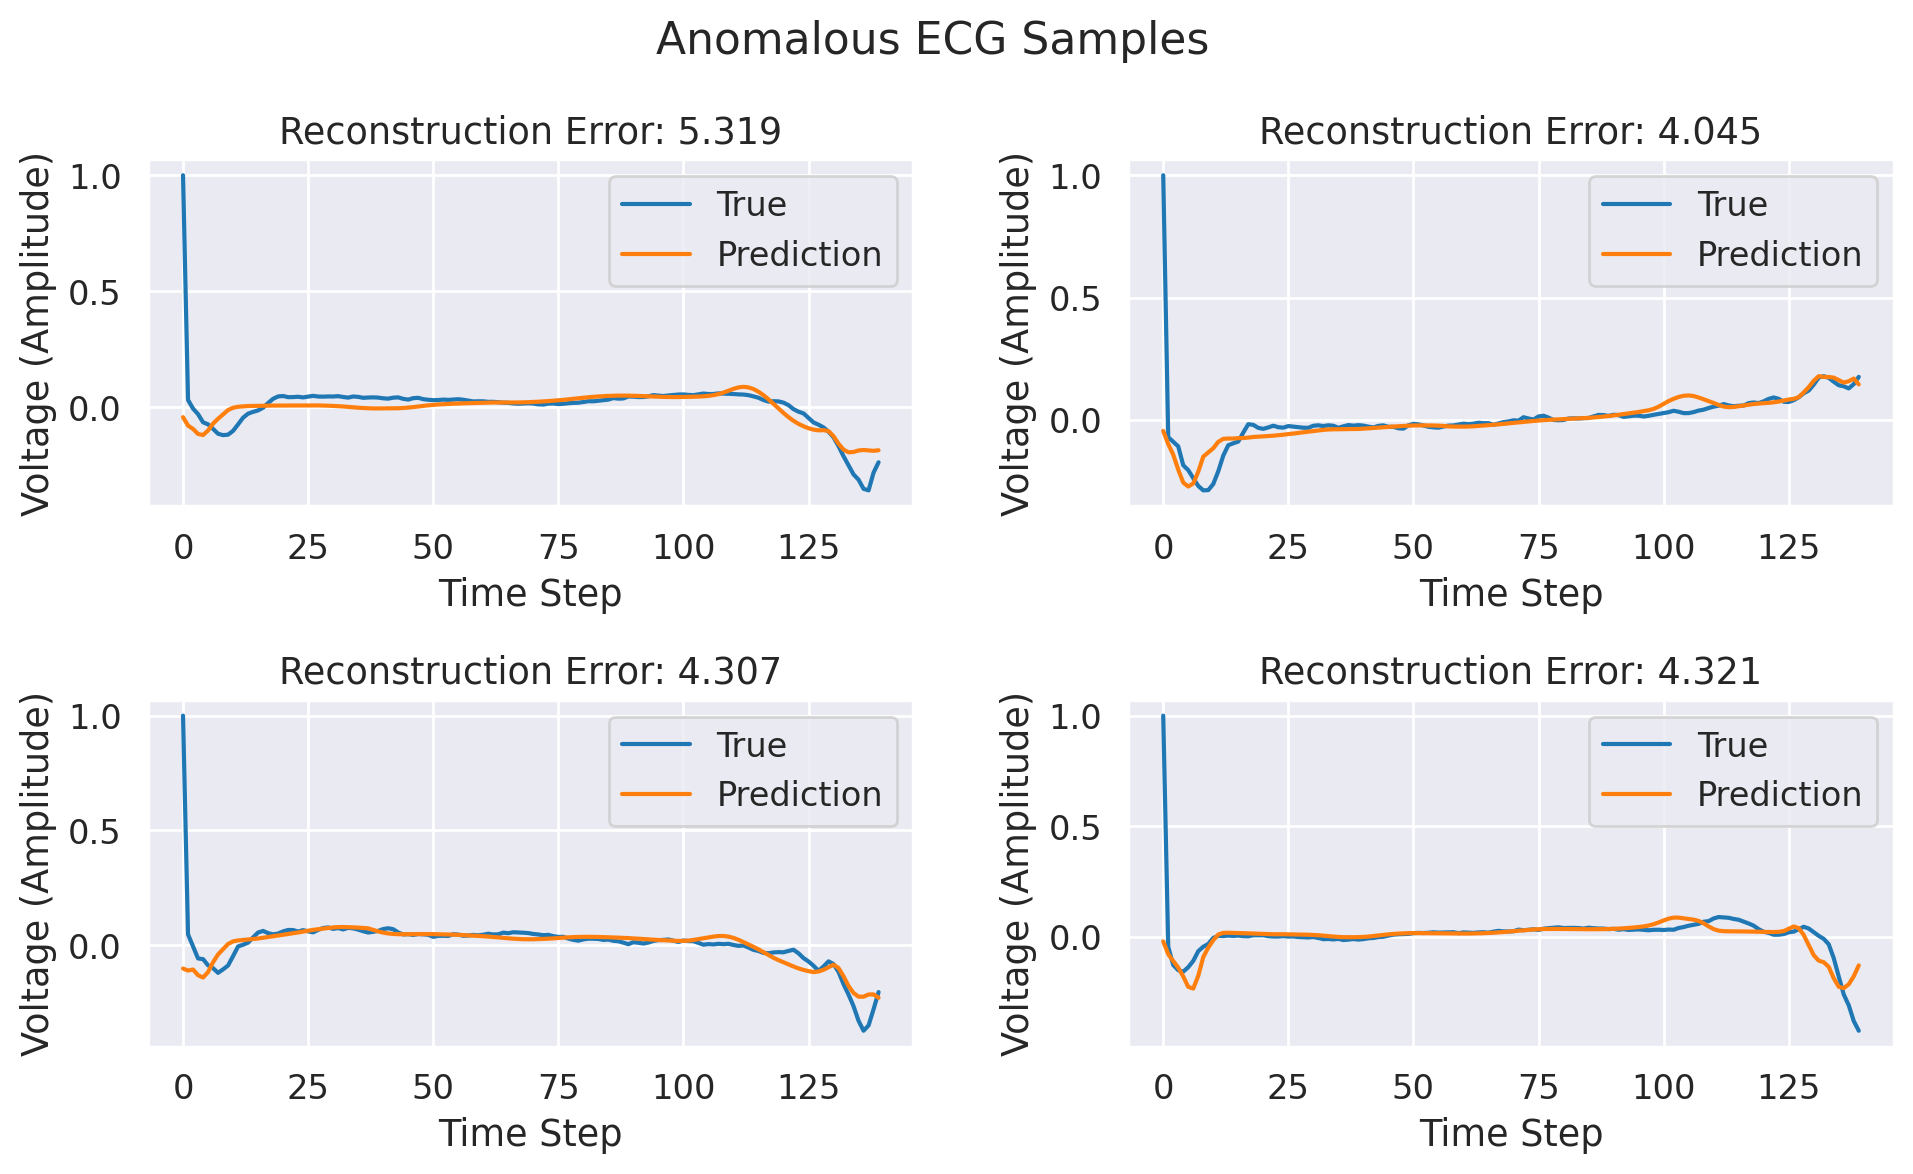

In [73]:
# Anomaly Samples
loss_pred_anomaly = plot_samples(anomaly_samples.to(device), model, title='Anomalous ECG Samples')

In [77]:
# Define the loss function
loss_fn = nn.L1Loss(reduction='sum')
# Move the model to CPU and set it to evaluation mode
model_cpu = model.to('cpu').eval()

In [78]:
def compute_losses(dataset, model, loss_fn):
    """Compute reconstruction losses for a dataset."""
    losses = []
    with torch.inference_mode():
        for instance in dataset:
            pred = model(instance)
            loss = loss_fn(pred, instance)
            losses.append(loss.item())
    return losses

In [79]:
# Compute losses for normal and anomaly datasets
normal_loss_lst = compute_losses(dataset_test, model_cpu, loss_fn)
anomaly_loss_lst = compute_losses(dataset_anomaly, model_cpu, loss_fn)

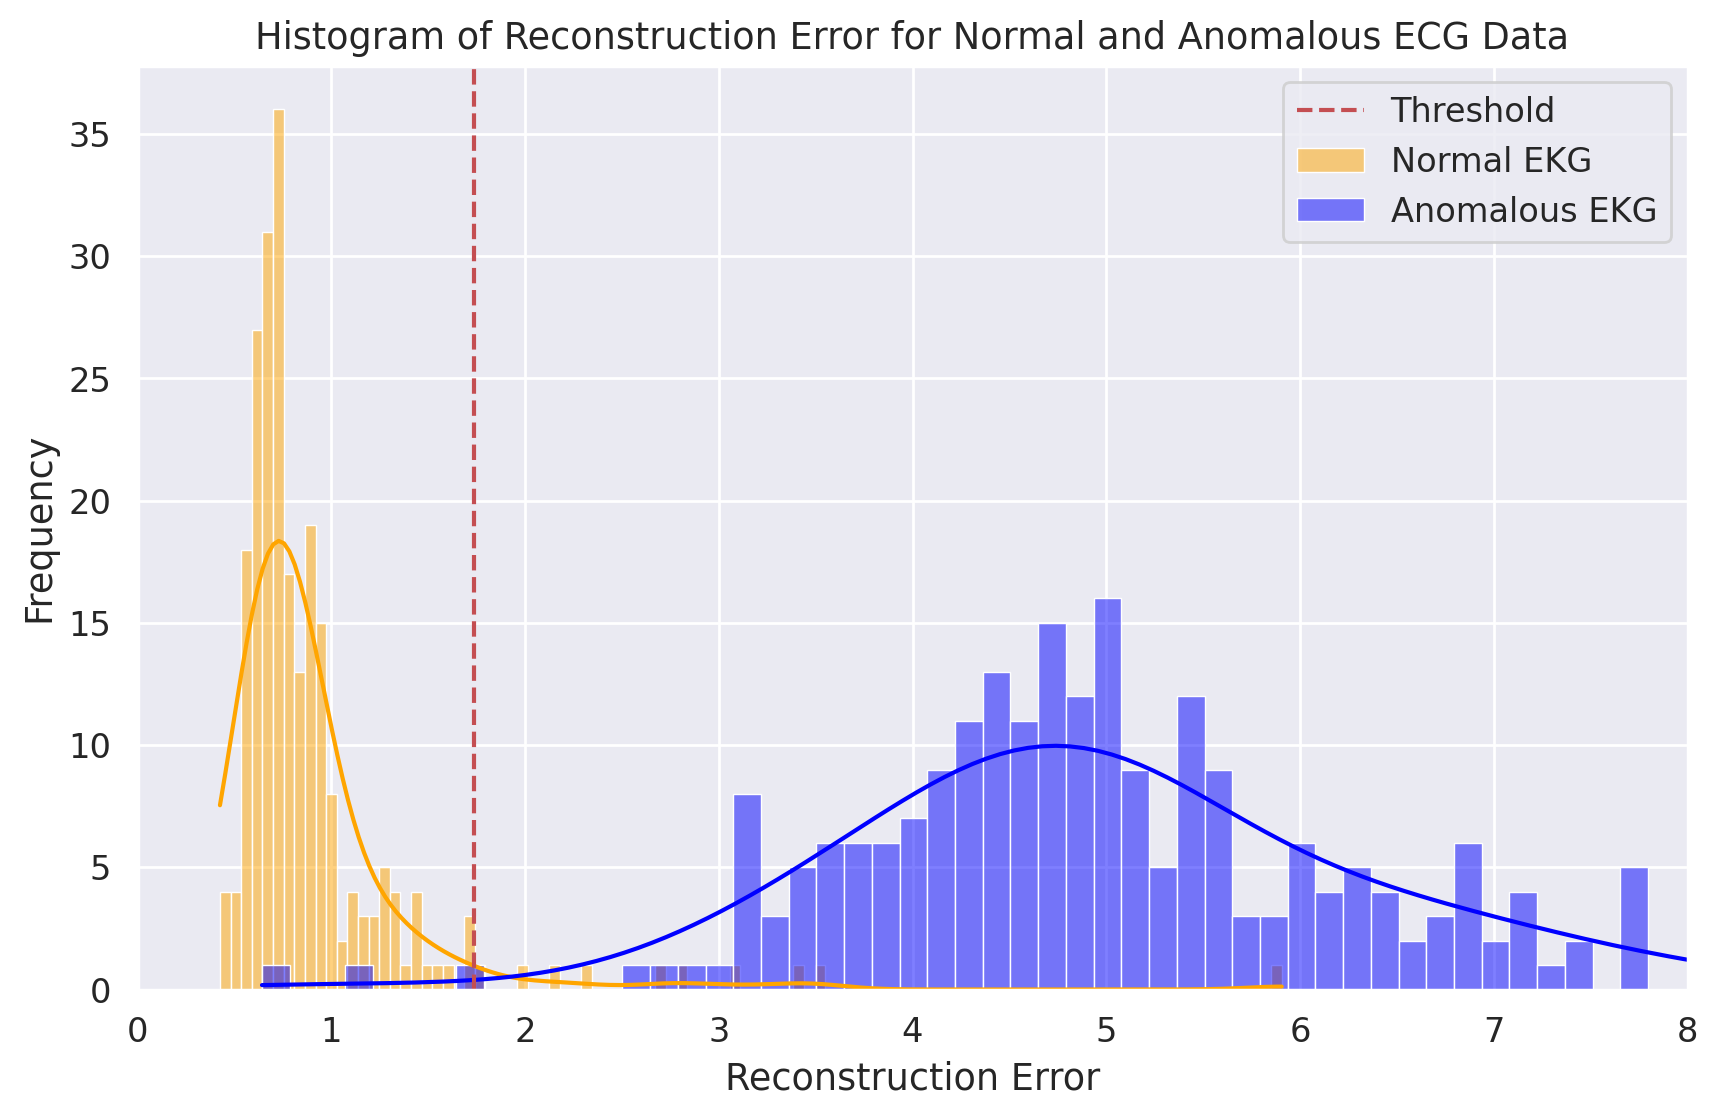

In [80]:
# Plot histograms of reconstruction errors
plt.figure(figsize=(10, 6))
sns.histplot(normal_loss_lst, bins=100, kde=True, label='Normal EKG', color='orange')
sns.histplot(random.choices(anomaly_loss_lst, k=len(normal_loss_lst)), bins=100, kde=True,
             label='Anomalous EKG', color='blue')

plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Error for Normal and Anomalous ECG Data')
plt.axvline(x=best_metrics['Best Threshold'], color='r', linestyle='--', label='Threshold')
plt.xlim(0, 8)
plt.legend()
plt.show()